<a href="https://colab.research.google.com/github/masa512/point_cloud/blob/main/PC_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import numpy as np
import torch.nn as nn
import math
import random

## SAB Model

Set Attention Block utilizes the input set to locally decide which part of the set to focus on. The SAB is defined as the following

MAB(X,X)

In [24]:
class MAB(nn.Module):
  def __init__(self,dim_Q, dim_K, dim_V, n_heads):
    super(MAB,self).__init__()
    self.dim_V = dim_V # Important since this is the output dimension
    self.n_heads = n_heads

    # Define the fully connected layer for key, val, query transform
    self.wk = nn.Linear(dim_K,self.dim_V)
    self.wq = nn.Linear(dim_Q,self.dim_V)
    self.wv = nn.Linear(dim_K,self.dim_V)

    self.ln = nn.LayerNorm(dim_V)
    self.relu = nn.ReLU()
  
  def forward(self,query,key,value):
    # Projection
    print(key.shape)
    K = self.wk(key)
    V = self.wv(value)
    Q = self.wq(query)

    batch_size = K.shape[0]

    # Good to note -> Batch,seq_len,emb_dim
    # Splitting ideally should give -> Batch,n_heads,seq_len,emb_dim

    # Let's reshape the input beforehand
    p_size = self.dim_V // self.n_heads
    K_split = torch.split(K,split_size_or_sections=p_size, dim = -1)
    V_split = torch.split(V,split_size_or_sections=p_size, dim = -1)
    Q_split = torch.split(Q,split_size_or_sections=p_size, dim = -1)

    K_ = torch.stack(K_split,dim=1)
    V_ = torch.stack(V_split,dim=1)
    Q_ = torch.stack(Q_split,dim=1)

    # Now the dot product activation

    A = torch.bmm(Q_.view(-1,Q_.shape[-2],Q_.shape[-1]),torch.transpose(K_.view(-1,K_.shape[-2],K_.shape[-1]),-1,-2))/math.sqrt(self.dim_V)
    A = A.reshape(batch_size,-1,A.shape[-2],A.shape[-1])
    # Softmax activation across embedding dimension
    SM = nn.Softmax(dim=-1)
    A = SM(A)


    
    # Apply activation on the Value and concatenate result
    Y = torch.bmm(A.view(-1,A.shape[-2],A.shape[-1]),V_.view(-1,V_.shape[-2],V_.shape[-1])) # Output with dim Batch, n_heads, seq_len, p_dim 
    Y = Y.reshape((batch_size,-1,Y.shape[-2],Y.shape[-1]))
    # Reorganize the dimensions to have Batch, seq_len, n_heads, p_dim
    Y = torch.permute(Y,dims=(0,2,1,3))
    Y = Y.reshape((Y.shape[0],Y.shape[1],-1))

    # Apply layer norm 
    Y = self.ln(Y)
    # Relu
    Y = self.relu(Y)
    return Y
  




In [25]:
class SAB(nn.Module):
  
  def __init__(self,in_dim,out_dim,n_heads):
    super(SAB,self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim

    # Initialize the SAB Block
    self.MAB = MAB(dim_Q = in_dim, dim_K = in_dim, dim_V = out_dim, n_heads = n_heads)
    
  def forward(self,X):
    Y = self.MAB(query = X,key = X,value = X)

    return Y


In [26]:
class ISAB(nn.Module):

  def __init__(self,in_dim,out_dim,n_heads,compressed_len):
    super(ISAB,self).__init__()
    self.in_dim = in_dim 
    self.out_dim = out_dim # Hidden dimension (latent)

    # Initialize the MAB Block here
    self.MAB1 = MAB(out_dim, in_dim, out_dim, n_heads)
    self.MAB2 = MAB(in_dim, out_dim, out_dim,n_heads)
    # Build a trainable tensor I that serves as the length_reduction query
    self.I = nn.Parameter(torch.Tensor(1,compressed_len,out_dim))
    nn.init.xavier_uniform_(self.I) # Xavier uniform dist.initialization

  def forward(self,X):
    H = self.MAB1(query = self.I.repeat(X.shape[0],1,1), key = X,value = X)
    Y = self.MAB2(query = X, key = H, value = H)
    return Y


In [27]:
class PMA(nn.Module):
  # This one preserves the input embedding dimmension, just for channel-wise operation
  def __init__(self,embedding_dim, n_heads, out_length):
    super(PMA,self).__init__()
    self.MAB = MAB(embedding_dim,embedding_dim,embedding_dim,n_heads)
    self.S = nn.Parameter(torch.Tensor(1,out_length,embedding_dim))
    nn.init.xavier_uniform_(self.S)

  def forward(self,X):
    Y = self.MAB(query = self.S.repeat(X.shape[0],1,1), value = X, key=X)
    return Y


# Test the MAB functionality

In [28]:
batch_size = 5
seq_len = 100

# Define a batch of random array of length seq_len
rand_seq = torch.rand(size=(seq_len,))

# We will only sample 75% indices from here
percentage = 0.75
N_sample = int(0.75*seq_len)
rand_indices = random.sample(range(seq_len),N_sample)
corr_values = torch.Tensor([rand_seq[i] for i in rand_indices])
# We will build a new tensor that appends the position on the audio sequence [idx,x]
X = torch.stack([torch.Tensor(rand_indices),corr_values],dim=-1)
X = X.reshape(1,X.shape[0],X.shape[1])


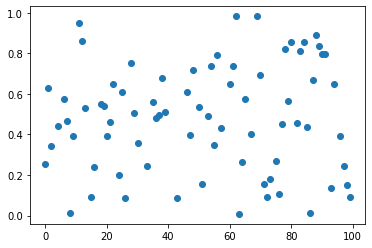

In [7]:
# Plot the data on the numberline for fun
import matplotlib.pyplot as plt 
f = plt.scatter(X[0,:,0],X[0,:,1])

In [8]:
# Define a MAB Block
dim_Q = 2
dim_K = 2
dim_V = 2
n_heads = 1
model = MAB(dim_Q, dim_K, dim_V, n_heads)

# Forward_pass
Y = model(query = X,key = X, value = X)

print(Y.shape)

torch.Size([1, 75, 2])


In [9]:
# Define a SAB Block
in_dim = 2
out_dim = 2
model = SAB(in_dim,out_dim,n_heads)

# Forward_pass
Y = model(X)
print(Y.shape)

torch.Size([1, 75, 2])


In [10]:
# Define a ISAB Block
in_dim = 2
out_dim = 3
compressed_len = 30
model = ISAB(in_dim,out_dim,n_heads,compressed_len)

# Forward Pass
Y = model(X)
print(Y.shape)

torch.Size([1, 75, 3])


In [11]:
# Define a PMA Block
embedding_dim = 2
n_heads = 1
out_length = 1

model = PMA(embedding_dim, n_heads, out_length)
Y = model(X)
print(Y.shape)

torch.Size([1, 1, 2])


# Building Encoder-Decoder network

In [12]:
class set_transformer(nn.Module):
  def __init__(self,in_dim,h_dim,out_dim,out_len,hidden_len,n_heads):
    super(set_transformer,self).__init__()
    self.enc = nn.Sequential(
        ISAB(in_dim=in_dim,out_dim=h_dim,n_heads=n_heads,compressed_len = hidden_len),
        ISAB(in_dim=h_dim,out_dim=h_dim,n_heads=n_heads,compressed_len = hidden_len)
    )
                            
    self.dec = nn.Sequential(
        PMA(embedding_dim=h_dim, n_heads=n_heads, out_length=out_len),
        SAB(in_dim=h_dim, out_dim=h_dim, n_heads=n_heads),
        SAB(in_dim=h_dim, out_dim=h_dim, n_heads=n_heads),
        nn.Linear(in_features=h_dim, out_features=out_dim)
    )
  
  def forward(self,X):
    Y = self.enc(X)
    Y = self.dec(Y)
    return Y


In [13]:
# Test the transformer
in_dim = 2
h_dim = 3
out_dim = 5 # num class
out_len = 1
hidden_len = 20
n_heads = 1

model = set_transformer(in_dim=in_dim,h_dim=h_dim,out_dim=out_dim,out_len=out_len,hidden_len=hidden_len,n_heads=n_heads)
# Run one forward on X
Y = model(X)

# print the shape
print(Y.shape)

torch.Size([1, 1, 5])


In [40]:
# Another test with arbitrary setup
in_dim = 129
h_dim = 99
out_dim = 3 # num class
out_len = 1
hidden_len = 100
n_heads = 3

model = set_transformer(in_dim=in_dim,h_dim=h_dim,out_dim=out_dim,out_len=out_len,hidden_len=hidden_len,n_heads=n_heads)

X = torch.rand((4,410,129))
Y = model(X)

torch.Size([4, 410, 129])
torch.Size([4, 100, 99])
torch.Size([4, 410, 99])
torch.Size([4, 100, 99])
torch.Size([4, 410, 99])
torch.Size([4, 1, 99])
torch.Size([4, 1, 99])


# Point-Cloud Audio Classification

## Data Processing

In [14]:
!pip install musdb
import musdb
mus = musdb.DB(download=True)




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 KB 42.7 MB/s eta 0:00:00
Done!


In [15]:
# Process dataset to merge all instruments
num_tracks = 30
DB = mus[:num_tracks]
fs = DB[0].rate
x = []
y = [] # (vocal,0), (bass,1), (drum,2)

for n in range(num_tracks):
  cur_track = DB[n].targets
  # get the vocal
  x.append(np.sum(cur_track['vocals'].audio,axis = 1))
  y.append(0)

  # get the bass
  x.append(np.sum(cur_track['bass'].audio,axis = 1))
  y.append(1)

  # get the drums
  x.append(np.sum(cur_track['drums'].audio,axis = 1))
  y.append(2)


print('data_size:',len(x))

data_size: 90


In [16]:
# Clipping
class RandomClip:
    def __init__(self, fraction):
        self.fraction = fraction
      

    def __call__(self, audio_data):
        # Audio datas are stored in list
        
        audio_length = audio_data[0].shape[0]
        clip_length = int(self.fraction * audio_length)
        if audio_length > clip_length:
          offset = random.randint(0, audio_length-clip_length)
          audio_data = [x[offset:(offset+clip_length)] for x in audio_data]

        
        return audio_data

In [17]:
# Cloud Audio extractor from STFT
def mel_to_cloud(mel_spectrum,frac_keep):
  """
  The sampling in time will be same across all freq axis
  Returns (F,1+floor(T*frac_keep)) tensor
  """
  F,T = mel_spectrum.shape
  N = int(frac_keep*T)
  lst = []
  rand_idx = random.sample(range(T),N) # Random indices of time sampled
  rand_idx.sort()
  # Sampled mel_spectrum
  rand_idx = torch.tensor(rand_idx,dtype=torch.long,requires_grad=False)
  mel_sampled = mel_spectrum[:,rand_idx]
  # Concat the idx onto mel_sampled
  Y = torch.concatenate([rand_idx.reshape(1,-1),mel_sampled],dim=0)
  
  return Y
    
  

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchaudio.transforms import MelScale
# Define the dataset
class lala_dataset(Dataset):

  def __init__(self,x,y,fs,n_fft=2048,transform = None,frac_keep = 0.7):

    # We will use the DB from our MUSDB but it will be open for the user to replace this functionality
    super(lala_dataset,self).__init__()
    # We will use just 5 songs
    self.X = x
    self.Y = y
    self.n_fft = n_fft
    self.fs = fs
    self.trans = transform # Clipping
    self.mel_transform = MelScale(n_mels = 128, sample_rate = self.fs, n_stft = self.n_fft)
    self.frac_keep = frac_keep # Only keep 70% of available data for simulating lacking there of
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    # Get audio array and corresponding label
    x = torch.tensor(self.X[idx])
    y = torch.tensor(self.Y[idx])

    # Apply STFT->Mel procedure
    S = abs(torch.stft(x,n_fft=self.n_fft,onesided=False, return_complex=True))
    S = S.type(torch.float)
    mel = self.mel_transform(S)
    
    # Normalize the spectrogram
    eps = 1e-8
    log_mel = torch.log(eps + mel)
    M = torch.max(log_mel)
    m = torch.min(log_mel)

    scaled = (log_mel - m)/(M-m)

    # Apply mel-to-cloud
    C = mel_to_cloud(scaled,frac_keep = self.frac_keep)
    # Swap the last two axis (Time,Freq)
    C = torch.transpose(C,-1,-2)
    print(C.shape)
    return C, torch.Tensor(y)

In [46]:
# Try initiating the dataset for debugging
ds = lala_dataset(x,y,fs=fs,n_fft=2048,transform =  RandomClip(fraction= 1/3) ,frac_keep = 0.7)
# Partition train and validation
rtrain = 0.8
N = ds.__len__()
Ntrain = int(0.8*N)
Nval = N - Ntrain
ds_train,ds_val = random_split(ds,[Ntrain,Nval])
# Define dataloaders
batch_size = 4
train_loader = DataLoader(ds_train,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(ds_val,batch_size=1,shuffle=False)

## Time for training our model

In [20]:
# Training loops

from tqdm import tqdm

def train(
    model = None, 
    device = 'cuda', 
    optimizer = None, 
    scheduler = None,
    train_loader = None, 
    val_loader = None, 
    num_epochs = 1,
    batch_size = 1,
):

    # Run the first network to
    # Epoch loss to return
    t_train_loss = []
    t_val_loss = []

    # Define loss
    criterion = nn.BCEWithLogitsLoss()

    for t in range(num_epochs):
      print(f"------------epoch{t+1}--------------")
      model.train() # train mode
      b_train_loss = [] # batch_loss for training
      b_val_loss = [] # batch_loss for validation

      # Batch loop
      for X,Y in tqdm(train_loader):
        # zero_gradient
        optimizer.zero_grad()

        # get the data needed
        X = X.to(device)
        Y = Y.to(device)

        Ypred = model(X) # The embedding prediction after Mixture with (-1,FT,K)
        
        # Evaluate the  loss
        loss = criterion(Input=Ypred,Target=Y) 

        # Backprop
        loss.backward()
        optimizer.step()
        # Append to b_train_loss (batch)
        b_train_loss.append(loss.item()/batch_size)

      # Evaluation over validation set
      model.eval()
      with torch.no_grad():
        for X,Y in val_loader:
          
          X = X.to(device) 
          Y = Y.to(device)

          Ypred = model(X) # The embedding prediction after Mixture with (-1,FT,K)
          # evaluate bce loss
          loss = criterion(Input=Ypred,Target=Y) 

          # append to b_val_loss (batch)
          b_val_loss.append(loss.item())

      
      # Save the losses to t_val/t_train loss
      t_train_loss.append(np.mean(b_train_loss))
      t_val_loss.append(np.mean(b_val_loss))

      # Print out the validation loss
      print(f'===> Epoch {t+1}: Train Loss -> {t_train_loss[-1]}')
      print(f'===> Epoch {t+1}: Validation Loss -> {t_val_loss[-1]}')

      # Proceed with schduler
      scheduler.step()
    # Return dictionary as needed
    return {
          'train_loss':t_train_loss,
          'val_loss':t_val_loss
    }


In [48]:
import torch.optim as optim
# Define the hyperparameter as well as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader
batch_size = 4
train_loader = DataLoader(ds_train,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(ds_val,batch_size=1,shuffle=False)

# Model Parameters
in_dim = 128 + 1
h_dim = 99
out_dim = 3 # num class
out_len = 1
hidden_len = 200
n_heads = 3

model = set_transformer(in_dim=in_dim,h_dim=h_dim,out_dim=out_dim,out_len=out_len,hidden_len=hidden_len,n_heads=n_heads)
model = model.to(device)

# Training Parameters
lr = 5e-4
num_epochs = 1
gamma = 0.95
optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

t_losses = train(
  model = model, 
  device = 'cuda', 
  optimizer = optimizer, 
  scheduler = scheduler,
  train_loader = train_loader, 
  val_loader = val_loader, 
  num_epochs = num_epochs,
  batch_size = batch_size,
)


------------epoch1--------------


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([410, 129])
torch.Size([410, 129])
torch.Size([410, 129])
torch.Size([410, 129])
torch.Size([4, 410, 129])


  0%|          | 0/18 [00:02<?, ?it/s]

torch.Size([4, 200, 99])
torch.Size([4, 410, 99])
torch.Size([4, 200, 99])
torch.Size([4, 410, 99])
torch.Size([4, 1, 99])
torch.Size([4, 1, 99])


TypeError: ignored